In [1]:
# %matplotlib inline

import matplotlib.pyplot as plt

# NOTE: Janky path addition required because we are now running from the `notebooks` directory
#       rather than the main `model_zoo` directory
import os
import sys

cwd = os.getcwd()
sys.path.insert(0, cwd.strip(os.path.basename(cwd))[:-1])
from load_run import load_run
from model_zoo.evaluators.ood_helpers import plot_ood_histogram_from_run_dir
sys.path.pop(0)

'/home/hamid/projects/model_zoo'

In [6]:
# Start by loading a two-step module. This run needs to have had the OOD Evaluator run on it already.
run_dir = '../runs/single_vae'
title = "VAE DE Trained on FMNIST"

# NOTE: Currently a (small) bug where the data redownloads into this directory rather than
#       pulling data which already exists. Delete this extra data folder as required.
load_dict = load_run(run_dir)
# load_dict has
#         "module": module,
#         "trainer": trainer,)
#         "train_loader": train_loader,
#         "valid_loader": valid_loader,
#         "test_loader": test_loader

# plot_ood_histogram_from_run_dir(
#     run_dir=run_dir,
#     low_dim=False,
#     range=[-200, -100],
#     # range=[-1000,1400],
#     title=title,
#     decision_height=700,
#     bins=100
# )

# plt.savefig(f"{title}.png")

In [32]:
import torch
from functorch import grad, vjp

def compute_largest_eigenval(model, data, max_iterations=10000, tolerance=1e-5):
    """Computes the absolute largest eigenvalue of the Hessian of the log_prob of model taken wrt data"""
    with torch.no_grad():
        # functorch grad requires a scalar function
        def log_prob_fn(x):
            return model.log_prob(x)[0, 0]
        _, hvp_fn = vjp(grad(log_prob_fn), data)
        
        # initialize power iteration method with random unit vector of data's shape
        eigenvec = torch.rand_like(data)
        eigenvec = eigenvec / torch.linalg.norm(eigenvec)
        eigenval = None
        
        # power iteration
        for i in range(max_iterations):
            # compute next eigenvec via HVP
            new_eigenvec = hvp_fn(eigenvec)[0]
            # estimated largest eigenvalue
            new_eigenval = torch.dot(new_eigenvec.flatten(), eigenvec.flatten()) / torch.linalg.norm(eigenvec)
            if eigenval != None:
                # check if estimate of largest eigenval has converged
                if abs(eigenval - new_eigenval) / abs(eigenval) < tolerance:
                    eigenval = new_eigenval
                    break
            # renormalize
            eigenvec = new_eigenvec / torch.linalg.norm(new_eigenvec)
            eigenval = new_eigenval

    return eigenval.item(), eigenvec

In [7]:
# Example:
model = load_dict['module']
test_loader = load_dict['test_loader']
single_x = test_loader.dataset.x[0]
two_x = test_loader.dataset.x[0:2]

# eigenval, eigenvec = compute_largest_eigenval(model, single_x)
# eigenval

In [5]:
# Another example:
# Computes the largest eigenval averaged over the batch of data inputs
eigenval, eigenvec = compute_largest_eigenval(model, two_x)
eigenval

-0.3243652880191803

In [8]:
# Computation of eigenvalues is not vectorized because functorch automatically averages over batches.
# is_data = test_loader.dataset.x[:1000]
# is_eivals = []
# for datapoint in is_data:
#     eigenval, eigenvec = compute_largest_eigenval(model, datapoint)
#     is_eivals.append(abs(eigenval))
# get OOS dataloader and repeat
from config import load_config_from_run_dir
cfg = load_config_from_run_dir(run_dir)
cfg


{'flatten': True,
 'denoising_sigma': None,
 'dequantize': False,
 'scale_data': True,
 'whitening_transform': False,
 'optimizer': 'adam',
 'lr': 0.001,
 'use_lr_scheduler': False,
 'max_epochs': 100,
 'max_grad_norm': 10,
 'early_stopping_metric': None,
 'max_bad_valid_epochs': None,
 'valid_metrics': ['loss'],
 'test_metrics': ['log_likelihood'],
 'train_batch_size': 128,
 'valid_batch_size': 128,
 'test_batch_size': 128,
 'make_valid_loader': True,
 'data_root': 'data/',
 'logdir_root': 'runs/',
 'dataset': 'cifar10',
 'model': 'vae',
 'gae': False,
 'latent_dim': 20,
 'single_sigma': True,
 'encoder_net': 'mlp',
 'encoder_hidden_dims': [256],
 'decoder_net': 'mlp',
 'decoder_hidden_dims': [256],
 'train_dataset_size': 45000,
 'data_shape': [3, 32, 32],
 'data_dim': 3072}

In [9]:
import torch
ood_dataset_map = {
    "mnist": "fashion-mnist",
    "fashion-mnist": "mnist",
    "svhn": "cifar10",
    "cifar10": "svhn"
}

from model_zoo.datasets import get_loaders
oos_train_loader, _, oos_test_loader = get_loaders(
    dataset=ood_dataset_map[cfg["dataset"]],
    data_root=cfg["data_root"],
    make_valid_loader=cfg["make_valid_loader"],
    train_batch_size=cfg["train_batch_size"],
    valid_batch_size=cfg.get("valid_batch_size", None),
    test_batch_size=cfg["test_batch_size"],
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)



In [10]:
test_loader.dataset.x.per

torch.Size([10000, 3, 32, 32])

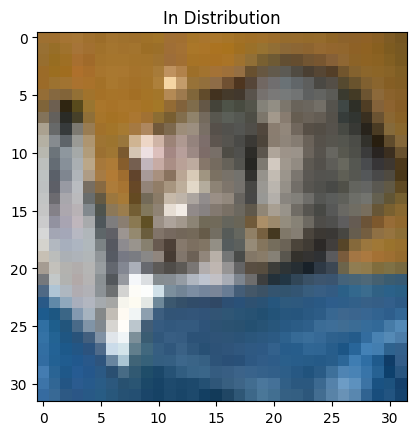

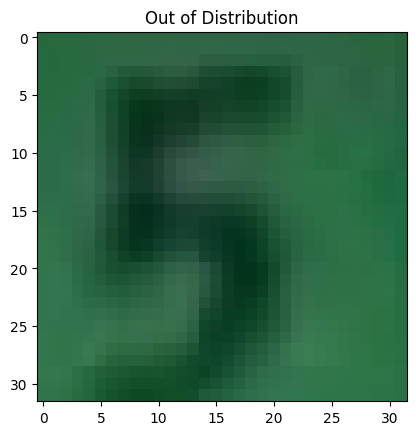

In [17]:
img_in_distribution = test_loader.dataset.x[0].permute(1, 2, 0).cpu().detach().numpy()
img_out_distribution = oos_test_loader.dataset.x[0].permute(1, 2, 0).cpu().detach().numpy()
img_in_distribution = img_in_distribution / 255
img_out_distribution = img_out_distribution / 255
# plt.show the images with RGB channels
# plt.imshow(img_in_distribution / 256)
# plt.show()
plt.imshow(img_in_distribution)
plt.title("In Distribution")
plt.show()
plt.imshow(img_out_distribution)
plt.title("Out of Distribution")
plt.show()

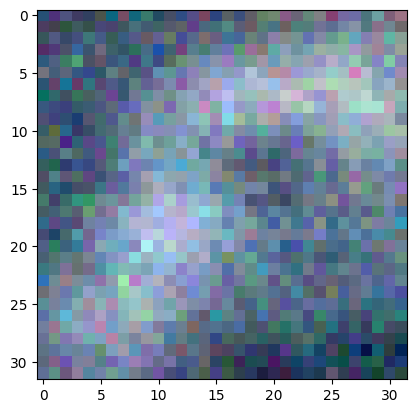

In [31]:
samp =  model.sample(1)[0].permute(1, 2, 0).cpu().detach().numpy()
samp = samp - samp.min()
samp = samp / samp.max()
plt.imshow(samp)

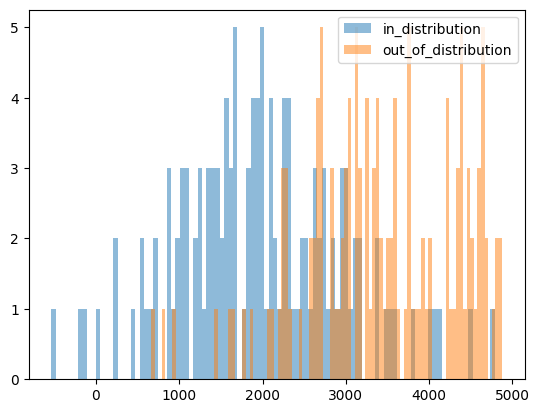

In [30]:
# run model.log_prob on all the oos_test_loader data and save the results
# then plot the histogram of the results
oos_log_probs = []
for tmp in oos_test_loader:
    x, y, _ = tmp
    t = model.log_prob(x).cpu().detach()
    # turn t into a list of floats
    t = t.flatten()
    t = t.tolist()
    oos_log_probs += t
    break
in_distribution_log_probs = []
for tmp in test_loader:
    x, y, _ = tmp
    t = model.log_prob(x).cpu().detach()
    # turn t into a list of floats
    t = t.flatten()
    t = t.tolist()
    in_distribution_log_probs += t
    break
# create a plot with both the histograms of in_distribution_log_probs and oos_log_probs
plt.hist(in_distribution_log_probs, bins=100, alpha=0.5, label='in_distribution')
plt.hist(oos_log_probs, bins=100, alpha=0.5, label='out_of_distribution')
plt.legend(loc='upper right')
plt.show()


In [ ]:
oos_data = oos_test_loader.dataset.x[:1000]
oos_eivals = []
for datapoint in oos_data:
    eigenval, eigenvec = compute_largest_eigenval(model, datapoint)
    oos_eivals.append(abs(eigenval))

Text(0.5, 1.0, 'VAE DE Trained on FMNIST')

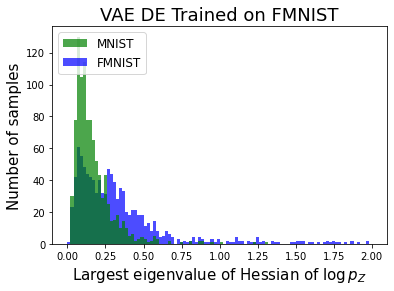

In [7]:
# Plot histograms of largest absolute eigenvalues for IS and OOS data.
label_map = {
    "fashion-mnist": "FMNIST",
    "mnist": "MNIST",
    "cifar10": "CIFAR-10",
    "svhn": "SVHN"
}
bins = 100
rnge=[0,2]

_, ax = plt.subplots(1, 1)

plt.hist(is_eivals, color="b", bins=bins, histtype="stepfilled",
    alpha=0.7, label=label_map[cfg["dataset"]], range=rnge)
plt.hist(oos_eivals, color="g", bins=bins, histtype="stepfilled",
    alpha=0.7, label=label_map[ood_dataset_map[cfg["dataset"]]], range=rnge)

xlabel = "Largest eigenvalue of Hessian of $\log p_Z$"
ax.set_xlabel(xlabel, fontsize=15)
ax.set_ylabel("Number of samples", fontsize=15)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=2, fontsize=12)

plt.title(title, fontsize=18)

# plt.savefig(f"{title}.png")

In [8]:
# Sanity check: compute full Hessian and then compute eigenvls exactly
from functorch import hessian, jacfwd
def log_prob_fn(x):
    return model.log_prob(x)[0, 0]
# This fails because hessian calls to vmap which does not handle mapping over functions that involve randomness
# The log_prob for VAE estimates the ELBO with random samples.
hessian(log_prob_fn)(two_x)
# jacfwd(jacfwd(log_prob_fn))(single_x)

RuntimeError: vmap: called random operation while in randomness error mode. Please either use the 'same' or 'different' randomness flags on vmap or perform the randomness operation out of vmap